<div style="border-radius:10px;
            border : black solid;
            background-color: #2C9215;
            font-size:160%;
            text-align: left">

<h1 style='; border:0; border-radius: 10px; text-shadow: 1px 1px black; font-weight: bold; color:#ffffff'><center> 📑 Detect Fake and Real News ~ Glove embeddings, LSTM 🎭 </center></h1>

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#2C9215; font-family:arial;color:#FFFFFF;font-size:150%;text-align:center;border-radius:55px 1px;">Load required libraries</p>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import re, string, unicodedata
from string import punctuation
from termcolor import colored
from collections import Counter


from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split


import keras
import tensorflow as tf
from keras.preprocessing import text, sequence
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer

import nltk
from nltk.corpus import stopwords
from textblob import Word
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet


from warnings import filterwarnings
filterwarnings('ignore')

from sklearn import set_config
set_config(print_changed_only = False)

print(colored("\nLIBRARIES WERE SUCCESFULLY IMPORTED...", "green"))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...



LIBRARIES WERE SUCCESFULLY IMPORTED...


<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#2C9215; font-family:arial;color:#FFFFFF;font-size:150%;text-align:center;border-radius:55px 1px;">Load datasets</p>

In [2]:
true_news = pd.read_csv("../input/fake-and-real-news-dataset/True.csv")
fake_news = pd.read_csv("../input/fake-and-real-news-dataset/Fake.csv")

print(colored("\nDATASETS WERE SUCCESFULLY LOADED...", "green"))


DATASETS WERE SUCCESFULLY LOADED...


<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#2C9215; font-family:arial;color:#FFFFFF;font-size:150%;text-align:center;border-radius:55px 1px;">Get some information about datasets</p>

In [3]:
true_news.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
fake_news.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
true_news["news_class"], fake_news["news_class"] = 1, 0

news = pd.concat([true_news, fake_news])

print(colored("\nDATASETS WERE SUCCESFULLY MERGED...", "green"))


DATASETS WERE SUCCESFULLY MERGED...


In [6]:
news.head()

,title,text,subject,date,news_class
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [7]:
news.tail()

,title,text,subject,date,news_class
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0
23480,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,Middle-east,"January 12, 2016",0


In [8]:
#get basic information about dataset

news.info(memory_usage = True, verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       44898 non-null  object
 1   text        44898 non-null  object
 2   subject     44898 non-null  object
 3   date        44898 non-null  object
 4   news_class  44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


In [9]:
#check whether there are duplicated values

news.duplicated().sum()

209

In [10]:
# drop duplicated values from the dataset

news.drop_duplicates(inplace = True)

print(colored("\nDUPLICATED VALUES WERE SUCCESFULLY DROPPED...", "green"))


DUPLICATED VALUES WERE SUCCESFULLY DROPPED...


In [11]:
#look class frequencies of 'news_class' variable

grouped_n = news.groupby("news_class").count()
grouped_n["title"]

news_class
0    23478
1    21211
Name: title, dtype: int64

In [12]:
#check whether there are 'nan' values

news.isnull().sum()

title         0
text          0
subject       0
date          0
news_class    0
dtype: int64

In [13]:
#look class frequencies of 'subject' variable

news["subject"].value_counts()

politicsNews       11220
worldnews           9991
News                9050
politics            6838
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

In [14]:
#the number of the texts

news["title"].count()

44689

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#2C9215; font-family:arial;color:#FFFFFF;font-size:150%;text-align:center;border-radius:55px 1px;">Data visualization</p>

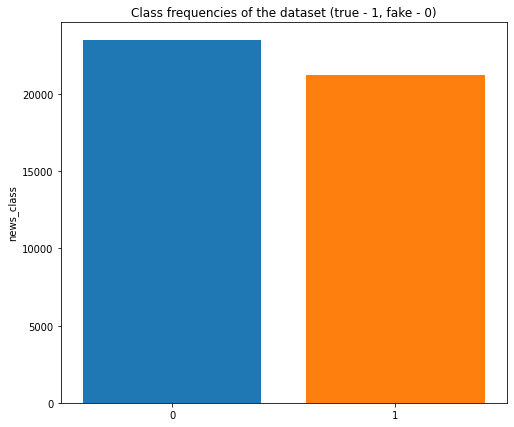

In [15]:
plt.figure(figsize = [8, 7], clear = True, facecolor = 'white')

sns.barplot(x = news["news_class"].value_counts().index,
            y = news["news_class"].value_counts(),
            saturation = 1).set(title = "Class frequencies of the dataset (true - 1, fake - 0)");

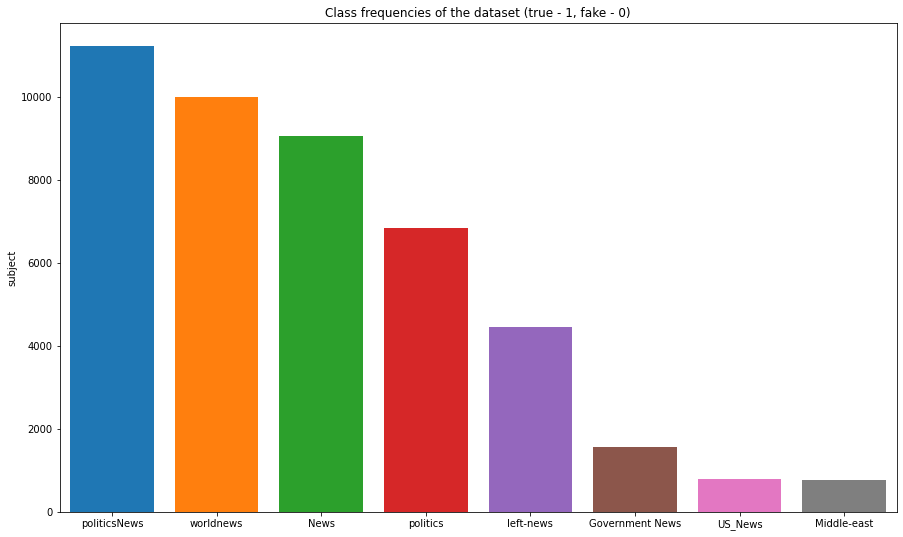

In [16]:
plt.figure(figsize = [15, 9], clear = True, facecolor = 'white')
sns.barplot(x = news["subject"].value_counts().index,
            y = news["subject"].value_counts(),
            saturation = 1).set(title = "Class frequencies of the dataset (true - 1, fake - 0)");

In [17]:
fig = px.pie(data_frame = news, names = "news_class", hole = 0.4, title = "counts in news_class",
             width = 1000, height = 500, color_discrete_sequence = px.colors.sequential.Sunset_r)

fig.update_traces(textposition = "inside", textinfo = "percent+label",
                  marker = dict(line = dict(width = 1.2, color = "#000000")))

fig.update_layout(title_x = 0.5, title_font = dict(size = 30), uniformtext_minsize = 25)

fig.show()

In [18]:
fig = px.pie(news, names = "subject", title = "counts in news_class", hole = 0.5,
            width = 1000, height = 500, color_discrete_sequence = px.colors.sequential.Sunset_r)

fig.update_traces(textposition = "inside", textinfo = "percent+label",
                  marker = dict(line = dict(width = 1.2, color = "#000000")))

fig.update_layout(title_x = 0.5, title_font = dict(size = 30), uniformtext_minsize = 25)

fig.show()

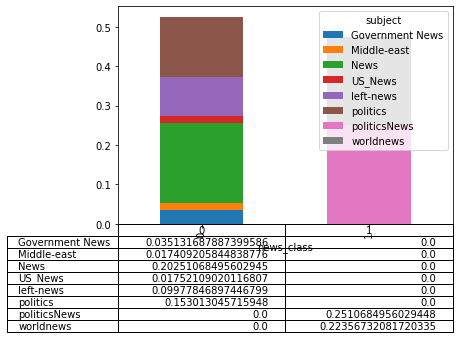

In [19]:
pd.crosstab(news["news_class"], news["subject"],
            normalize = True).plot(kind = "bar", 
                                   backend = "matplotlib",
                                   legend = True, table = True, stacked = True);

<function matplotlib.pyplot.show(close=None, block=None)>

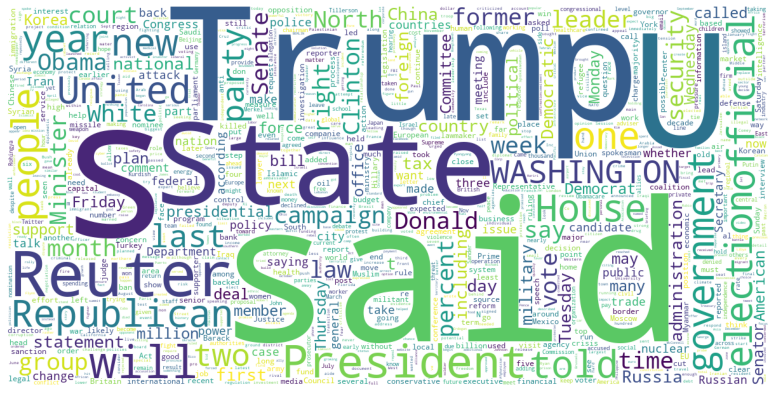

In [20]:
#Wordcloud for true news

text = " ".join(i for i in true_news.text)

wc = WordCloud(background_color = "white", width = 1200, height = 600,
               contour_width = 0, contour_color = "red", max_words = 1000,
               scale = 1, collocations = False, repeat = True, min_font_size = 1)

wc.generate(text)

plt.figure(figsize = [15, 7])
plt.imshow(wc)
plt.axis("off")
plt.show

In [21]:
news.tail(n = 10)

,title,text,subject,date,news_class
23471,Seven Iranians freed in the prisoner swap have...,"21st Century Wire says This week, the historic...",Middle-east,"January 20, 2016",0
23472,#Hashtag Hell & The Fake Left,By Dady Chery and Gilbert MercierAll writers ...,Middle-east,"January 19, 2016",0
23473,Astroturfing: Journalist Reveals Brainwashing ...,Vic Bishop Waking TimesOur reality is carefull...,Middle-east,"January 19, 2016",0
23474,The New American Century: An Era of Fraud,Paul Craig RobertsIn the last years of the 20t...,Middle-east,"January 19, 2016",0
23475,Hillary Clinton: ‘Israel First’ (and no peace ...,Robert Fantina CounterpunchAlthough the United...,Middle-east,"January 18, 2016",0
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0
23480,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,Middle-east,"January 12, 2016",0


<function matplotlib.pyplot.show(close=None, block=None)>

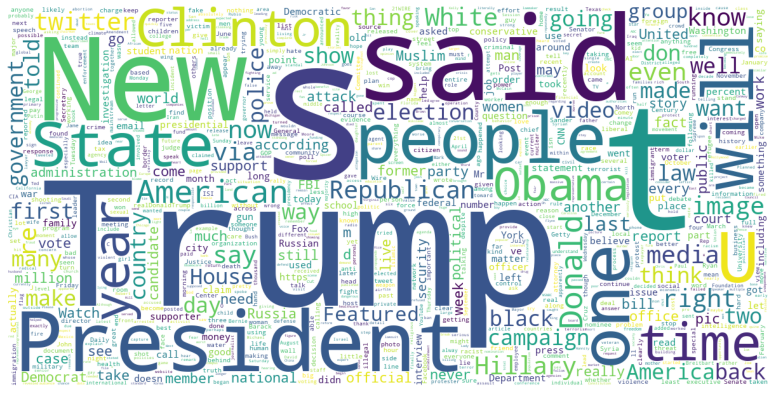

In [22]:
#Wordcloud for fake news

text = " ".join(i for i in fake_news.text)

wc = WordCloud(background_color = "white", width = 1200, height = 600,
               contour_width = 0, contour_color = "red", max_words = 1000,
               scale = 1, collocations = False, repeat = True, min_font_size = 1)

wc.generate(text)

plt.figure(figsize = [15, 7])
plt.imshow(wc)
plt.axis("off")
plt.show

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#2C9215; font-family:arial;color:#FFFFFF;font-size:150%;text-align:center;border-radius:55px 1px;">Preprocess the dataset</p>

In [23]:
news["text"] = news["text"] + " " + news["title"]
news.drop(["title", "date", "subject"], axis = 1, inplace = True)

print(colored("\n'TITLE','DATE' AND 'SUBJECT' COLUMNS WERE SUCCESFULLY DROPPED...", "green"))


'TITLE','DATE' AND 'SUBJECT' COLUMNS WERE SUCCESFULLY DROPPED...


In [24]:
#convert uppercase letters to lowercase letters

news["text"] = news["text"].apply(lambda x: " ".join(x.lower() for x in x.split()))

print(colored("\nCONVERTED SUCCESFULLY...", "green"))


CONVERTED SUCCESFULLY...


In [25]:
#delete punctuation marks

news["text"] = news["text"].str.replace('[^\w\s]','')

print(colored("\nDELETED PUNCTUATION MARKS SUCCESFULLY...", "green"))


DELETED PUNCTUATION MARKS SUCCESFULLY...


In [26]:
#delete numbers

news["text"] = news["text"].str.replace('\d','')

print(colored("\n NUMBERS DELETED SUCCESFULLY...", "green"))


 NUMBERS DELETED SUCCESFULLY...


In [27]:
#delete stopwords

stop_words = set(stopwords.words("english"))
punctuation = list(string.punctuation)
stop_words.update(punctuation)

news["text"] = news["text"].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

print(colored("\nSTOPWORDS DELETED SUCCESFULLY...", "green"))


STOPWORDS DELETED SUCCESFULLY...


In [28]:
#lemmatization. That is, we get the roots of the words

news["text"] = news["text"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

print(colored("\nLEMMATIZED SUCCESFULLY...", "green"))


LEMMATIZED SUCCESFULLY...


In [29]:
#remove URLs

news["text"] = news["text"].apply(lambda x: " ".join(re.sub(r'http\S+', '', x) for x in x.split()))

print(colored("\nURLs WERE SUCCESFULLY REMOVED...", "green"))


URLs WERE SUCCESFULLY REMOVED...


In [30]:
#look at the latest condition of the dataset

news.head(n = 10).style.background_gradient(cmap = "summer")

,text,news_class
0,washington reuters head conservative republican faction u congress voted month huge expansion national debt pay tax cut called fiscal conservative sunday urged budget restraint keeping sharp pivot way among republican u representative mark meadow speaking cbs face nation drew hard line federal spending lawmaker bracing battle january return holiday wednesday lawmaker begin trying pas federal budget fight likely linked issue immigration policy even november congressional election campaign approach republican seek keep control congress president donald trump republican want big budget increase military spending democrat also want proportional increase nondefense discretionary spending program support education scientific research infrastructure public health environmental protection trump administration already willing say going increase nondefense discretionary spending percent meadow chairman small influential house freedom caucus said program democrat saying thats enough need give government pay raise percent fiscal conservative dont see rationale eventually run people money said meadow among republican voted late december party debtfinanced tax overhaul expected balloon federal budget deficit add trillion year trillion national debt interesting hear mark talk fiscal responsibility democratic u representative joseph crowley said cbs crowley said republican tax bill would require united state borrow trillion paid future generation finance tax cut corporation rich one least fiscally responsible bill weve ever seen passed history house representative think going paying many many year come crowley said republican insist tax package biggest u tax overhaul year boost economy job growth house speaker paul ryan also supported tax bill recently went meadow making clear radio interview welfare entitlement reform party often call would top republican priority republican parlance entitlement program mean food stamp housing assistance medicare medicaid health insurance elderly poor disabled well program created washington assist needy democrat seized ryans early december remark saying showed republican would try pay tax overhaul seeking spending cut social program goal house republican may take back seat senate vote democrat needed approve budget prevent government shutdown democrat use leverage senate republican narrowly control defend discretionary nondefense program social spending tackling issue dreamer people brought illegally country child trump september put march expiration date deferred action childhood arrival daca program protects young immigrant deportation provides work permit president said recent twitter message want funding proposed mexican border wall immigration law change exchange agreeing help dreamer representative debbie dingell told cbs favor linking issue policy objective wall funding need daca clean said wednesday trump aide meet congressional leader discus issue followed weekend strategy session trump republican leader jan white house said trump also scheduled meet sunday florida republican governor rick scott want emergency aid house passed billion aid package hurricane florida texas puerto rico wildfire california package far exceeded billion requested trump administration senate yet voted aid u budget fight loom republican flip fiscal script,1
1,washington reuters transgender people allowed first time enlist u military starting monday ordered federal court pentagon said friday president donald trump administration decided appeal ruling blocked transgender ban two federal appeal court one washington one virginia last week rejected administration request put hold order lower court judge requiring military begin accepting transgender recruit jan justice department official said administration challenge ruling department defense announced releasing independent study issue coming week rather litigate interim appeal occurs administration decided wait dod study continue defend president lawful auth

In [31]:
#get every words from dataset and append them to 'corpus' list
corpus = []
for i in news.text:
    for j in i.split():
        corpus.append(j.strip())

#count the words
counter = Counter(corpus)
common_words = counter.most_common(15)
dict(common_words)

{'trump': 142083,
 'said': 129065,
 'u': 68106,
 'state': 59332,
 'would': 55069,
 'president': 54472,
 'people': 41789,
 'republican': 39843,
 'one': 37357,
 'year': 34825,
 'new': 32550,
 'also': 31031,
 'clinton': 29889,
 'house': 29499,
 'say': 29111}

<function matplotlib.pyplot.show(close=None, block=None)>

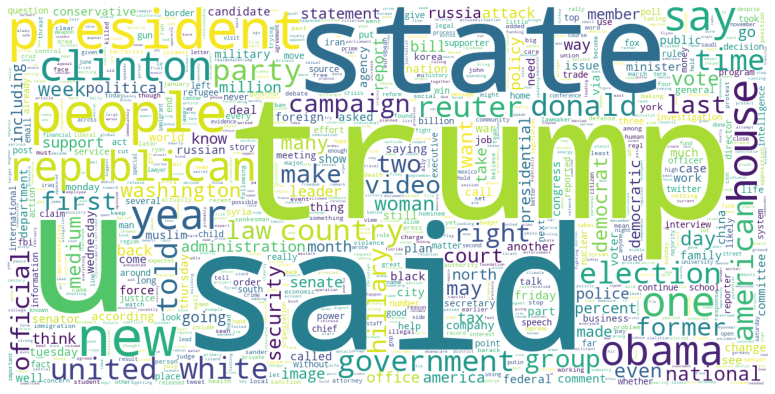

In [32]:
#Wordcloud for whole dataset

text = " ".join(i for i in news.text)

wc = WordCloud(background_color = "white", width = 1200, height = 600,
               contour_width = 0, contour_color = "red", max_words = 1000,
               scale = 1, collocations = False, repeat = True, min_font_size = 1)

wc.generate(text)

plt.figure(figsize = [15, 7])
plt.imshow(wc)
plt.axis("off")
plt.show

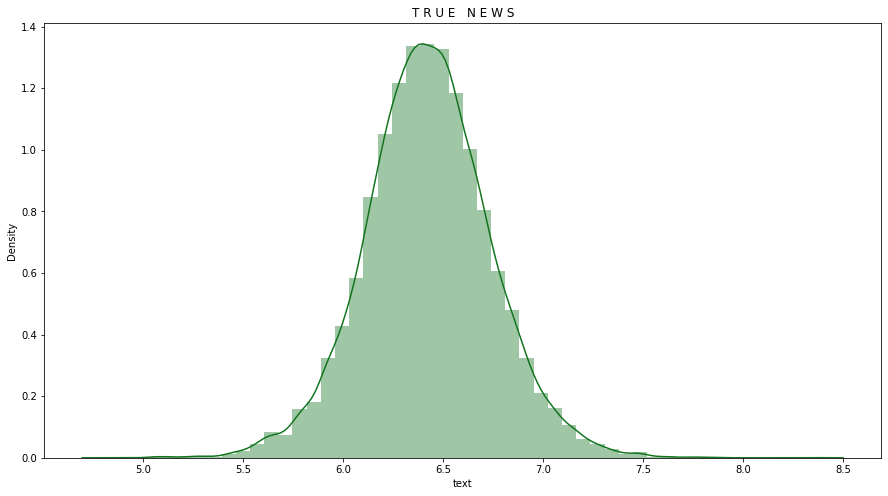

In [33]:
#average word length in true news

fig,ax = plt.subplots(figsize = (15, 8))
text_words = news[news["news_class"] == 1]["text"].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(text_words.map(lambda x: np.mean(x)), color = "#12741F", ax = ax).set_title("T R U E   N E W S");

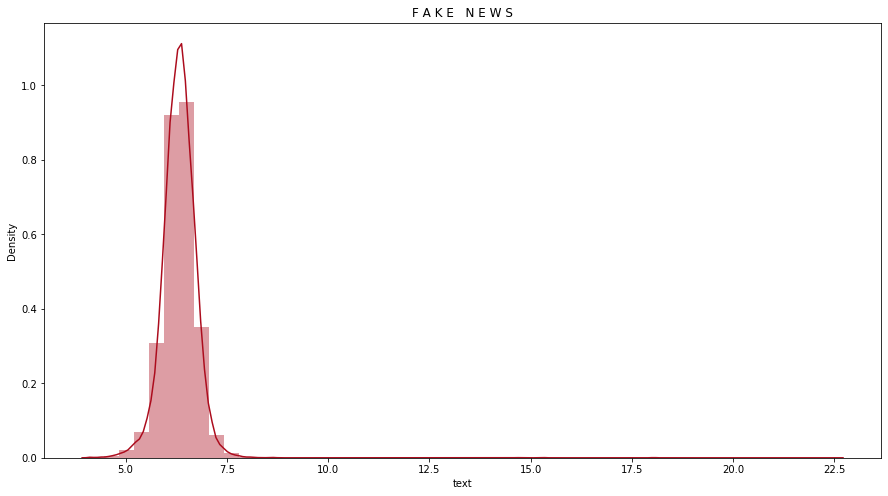

In [34]:
#average word length in fake news

fig, ax = plt.subplots(figsize = (15, 8))
text_words = news[news["news_class"] == 0]["text"].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(text_words.map(lambda x: np.mean(x)), color = "#AC0C1D", ax = ax).set_title("F A K E   N E W S");

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#2C9215; font-family:arial;color:#FFFFFF;font-size:150%;text-align:center;border-radius:55px 1px;">Prepare the dataset for machine learning models</p>

In [35]:
#divide the dataset into test and train sets

x = news["text"]
y = news["news_class"]

train_x, test_x, train_y, test_y = train_test_split(x, y,
                                                    test_size = 0.20,
                                                    shuffle = True,
                                                    random_state = 11)

print(colored("\nDIVIDED SUCCESFULLY...", "green"))


DIVIDED SUCCESFULLY...


In [36]:
print(train_x.shape, test_x.shape)

(35751,) (8938,)


In [37]:
tokenizer = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(train_x)

tokenized_train = tokenizer.texts_to_sequences(train_x)
tokenized_test = tokenizer.texts_to_sequences(test_x)

train_x = sequence.pad_sequences(tokenized_train, maxlen = 300)
test_x = sequence.pad_sequences(tokenized_test, maxlen = 300)

In [38]:
GLOVE_EMBEDDING = "../input/glove-twitter/glove.twitter.27B.100d.txt"

In [39]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype = "float32")
embeddings_index = dict(get_coefs(*g.rstrip().rsplit(" ")) for g in open(GLOVE_EMBEDDING))

#_________________________________________________________________________________________#

#_________________________________________________________________________________________#

embeddings = np.stack(embeddings_index.values())
embedding_mean, embedding_std = embeddings.mean(), embeddings.std()
embedding_size = embeddings.shape[1]

word_index = tokenizer.word_index
nb_words = min(10000, len(word_index))

embedding_matrix = embedding_matrix = np.random.normal(embedding_mean, embedding_std, (nb_words, embedding_size))
for word, i in word_index.items():
    if i >= 10000:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [40]:
lr_reduce = ReduceLROnPlateau(monitor = "val_accuracy", patience = 2, factor = 0.5, min_lr = 0.00001)

In [41]:
model = Sequential()

model.add(Embedding(10000,
                    output_dim = 100,
                    weights = [embedding_matrix],
                    input_length = 300,
                    trainable = False))

model.add(LSTM(units = 128,
               return_sequences = True,
               recurrent_dropout = 0.3,
               dropout = 0.3))

model.add(LSTM(units = 64,
               recurrent_dropout = 0.15,
               dropout = 0.15))

model.add(Dense(units = 32,
                activation = "relu"))

model.add(Dense(1,
                activation = "sigmoid"))

model.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.01),
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

2022-12-01 15:19:05.908286: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 15:19:05.911682: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 15:19:05.912358: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 15:19:05.913216: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 300, 128)          117248    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,168,769
Trainable params: 168,769
Non-trainable params: 1,000,000
_________________________________________________________________


In [43]:
history = model.fit(train_x,
                    train_y,
                    batch_size = 128,
                    validation_data = (test_x, test_y),
                    epochs = 10,
                    callbacks = [lr_reduce])

2022-12-01 15:19:09.403412: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
280/280 [==============================] - 701s 2s/step - loss: 0.1388 - accuracy: 0.9442 - val_loss: 0.0502 - val_accuracy: 0.9848
Epoch 2/10
280/280 [==============================] - 694s 2s/step - loss: 0.0398 - accuracy: 0.9866 - val_loss: 0.0207 - val_accuracy: 0.9942
Epoch 3/10
280/280 [==============================] - 688s 2s/step - loss: 0.0267 - accuracy: 0.9916 - val_loss: 0.0165 - val_accuracy: 0.9941
Epoch 4/10
280/280 [==============================] - 689s 2s/step - loss: 0.0235 - accuracy: 0.9925 - val_loss: 0.0145 - val_accuracy: 0.9959
Epoch 5/10
280/280 [==============================] - 689s 2s/step - loss: 0.0195 - accuracy: 0.9933 - val_loss: 0.0111 - val_accuracy: 0.9961
Epoch 6/10
280/280 [==============================] - 680s 2s/step - loss: 0.0297 - accuracy: 0.9903 - val_loss: 0.0297 - val_accuracy: 0.9916
Epoch 7/10
280/280 [==============================] - 691s 2s/step - loss: 0.0209 - accuracy: 0.9932 - val_loss: 0.0143 - val_accuracy: 0.9956

In [44]:
print("Model accuracy on the train set: ", model.evaluate(train_x, train_y)[1])
print("Model accuracy on the test set: ", model.evaluate(test_x, test_y)[1])

1118/1118 [==============================] - 155s 138ms/step - loss: 0.0056 - accuracy: 0.9981
Model accuracy on the train set:  0.9980979561805725
280/280 [==============================] - 38s 137ms/step - loss: 0.0127 - accuracy: 0.9968
Model accuracy on the test set:  0.9967554211616516


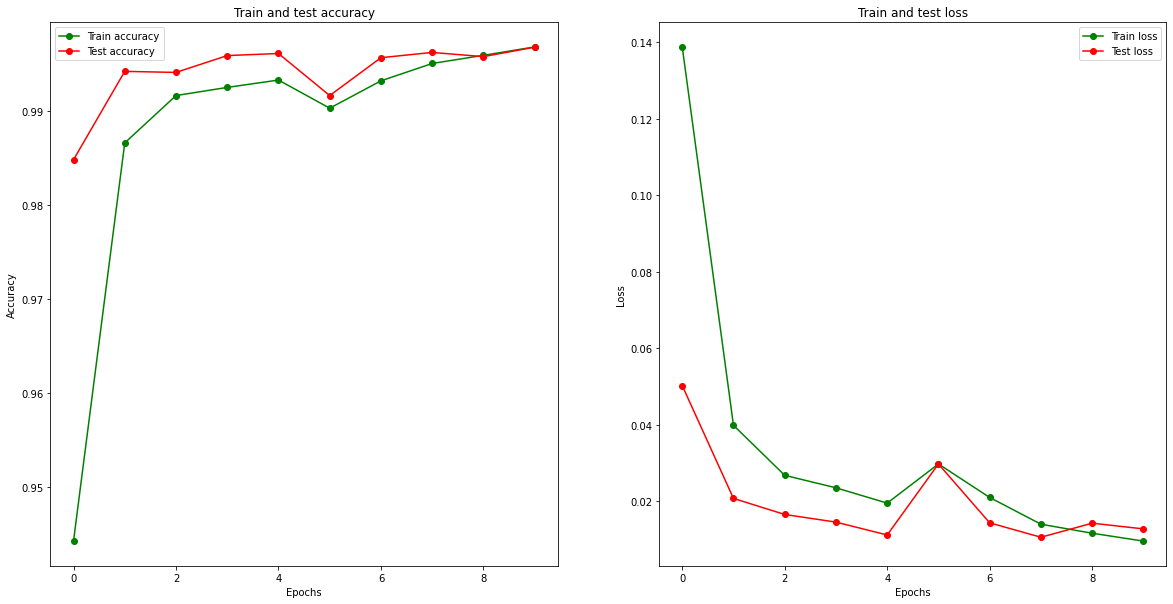

In [45]:
epochs = [i for i in range(10)]

fig, ax = plt.subplots(1, 2)
train_acc = history.history["accuracy"]
train_loss = history.history["loss"]
val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]
fig.set_size_inches(20, 10)

ax[0].plot(epochs, train_acc, "go-", label = "Train accuracy")
ax[0].plot(epochs, val_acc, "ro-", label = "Test accuracy")
ax[0].set_title("Train and test accuracy")
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, "go-", label = "Train loss")
ax[1].plot(epochs, val_loss, "ro-", label = "Test loss")
ax[1].set_title("Train and test loss")
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [46]:
prediction = model.predict(test_x)
classes_pred = np.argmax(prediction, axis = 1)

print(classification_report(test_y, classes_pred))

              precision    recall  f1-score   support

           0       0.52      1.00      0.68      4633
           1       0.00      0.00      0.00      4305

    accuracy                           0.52      8938
   macro avg       0.26      0.50      0.34      8938
weighted avg       0.27      0.52      0.35      8938



[[4633    0]
 [4305    0]]


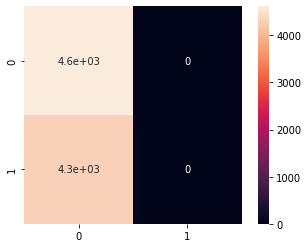

In [47]:
conf_mat = confusion_matrix(test_y, classes_pred)
print(conf_mat)

sns.heatmap(conf_mat, square = True, annot = True, robust = True)
plt.show()

### References

https://www.kaggle.com/code/madz2000/nlp-using-glove-embeddings-99-87-accuracy

# Thank you all 🙂